## Dataset import and exploration
- https://www.kaggle.com/shelvigarg/wine-quality-dataset
- Refer to https://github.com/better-data-science/TensorFlow/blob/main/003_TensorFlow_Classification.ipynb for detailed preparation instructions

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (24, 6)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
warnings.filterwarnings('ignore')

df = pd.read_csv('data/winequalityN.csv')
df.sample(5)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
3015,white,7.2,0.320,0.30,8.25,0.020,14.0,104.0,0.99362,2.99,0.44,11.4,6
3406,white,5.6,0.320,0.33,7.40,0.037,25.0,95.0,0.99268,3.25,0.49,11.1,6
3966,white,5.4,0.185,0.19,7.10,0.048,36.0,110.0,0.99438,3.26,0.41,9.5,6
946,white,8.2,0.345,1.00,18.20,0.047,55.0,205.0,0.99965,2.96,0.43,9.6,5
256,white,6.3,0.350,0.30,5.70,0.035,8.0,97.0,0.99270,3.27,0.41,11.0,7


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Prepare the data
df = df.dropna()
df['is_white_wine'] = [1 if typ == 'white' else 0 for typ in df['type']]
df['is_good_wine'] = [1 if quality >= 6 else 0 for quality in df['quality']]
df.drop(['type', 'quality'], axis=1, inplace=True)

# Train/test split
X = df.drop('is_good_wine', axis=1)
y = df['is_good_wine']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, random_state=42
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<br>

## Modelling
- Let's declare a function that builds and trains the model
- We're doing this because we'll train the exact same model multiple times

In [3]:
import tensorflow as tf
tf.random.set_seed(42)

Init Plugin
Init Graph Optimizer
Init Kernel


In [7]:
def build_and_train(callbacks: list, num_epochs: int = 5) -> tf.keras.Sequential:
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
    )

    model.fit(
        X_train_scaled, 
        y_train, 
        epochs=num_epochs,
        validation_data=(X_test_scaled, y_test),
        callbacks=callbacks,
        verbose=0
    )
    
    return model

<br>

## Basic custom callback
- We'll define what happens on:
    - **Train begin** - we'll just print the time at which the training started
    - **Train end** - we'll print the time at which the training finsihed, how much time did the training last, and evaluation metrics (accuracy, precision, recall, f1) on the test set

In [8]:
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.time_started = None
        self.time_finished = None
        
    def on_train_begin(self, logs=None):
        self.time_started = datetime.now()
        print(f'TRAINING STARTED | {self.time_started}\n')
        
    def on_train_end(self, logs=None):
        self.time_finished = datetime.now()
        train_duration = str(self.time_finished - self.time_started)
        print(f'\nTRAINING FINISHED | {self.time_finished} | Duration: {train_duration}')
        
        tl = f"Training loss:       {logs['loss']:.5f}"
        ta = f"Training accuracy:   {logs['accuracy']:.5f}"
        vl = f"Validation loss:     {logs['val_loss']:.5f}"
        va = f"Validation accuracy: {logs['val_accuracy']:.5f}"
        
        print('\n'.join([tl, vl, ta, va]))

- Pass in the callback like this:

In [9]:
model = build_and_train(
    callbacks=[MyCallback()]
)

TRAINING STARTED | 2021-10-29 15:49:21.494512


TRAINING FINISHED | 2021-10-29 15:49:26.210987 | Duration: 0:00:04.716475
Training loss:       0.46859
Validation loss:     0.46578
Training accuracy:   0.77988
Validation accuracy: 0.77726


<br>

## Extending the callback functionality
- We'll also modify the behavior for a single epoch:
    - **Epoch begin** - just save the time to the constructor
    - **Epoch end** - Calculate epoch duration and keep track of the training and validation metrics. We'll print them in a somewhat of a visually apealing way

In [10]:
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.time_started = None
        self.time_finished = None
        self.time_curr_epoch = None
        
    def on_train_begin(self, logs=None):
        self.time_started = datetime.now()
        print(f'TRAINING STARTED | {self.time_started}\n')
        
    def on_train_end(self, logs=None):
        self.time_finished = datetime.now()
        train_duration = str(self.time_finished - self.time_started)
        print(f'\nTRAINING FINISHED | {self.time_finished} | Duration: {train_duration}')
        
        tl = f"Training loss:       {logs['loss']:.5f}"
        ta = f"Training accuracy:   {logs['accuracy']:.5f}"
        vl = f"Validation loss:     {logs['val_loss']:.5f}"
        va = f"Validation accuracy: {logs['val_accuracy']:.5f}"
        
        print('\n'.join([tl, vl, ta, va]))
        
    def on_epoch_begin(self, epoch, logs=None):
        self.time_curr_epoch = datetime.now()
        
    def on_epoch_end(self, epoch, logs=None):
        epoch_dur = (datetime.now() - self.time_curr_epoch).total_seconds()
        tl = logs['loss']
        ta = logs['accuracy']
        vl = logs['val_loss']
        va = logs['val_accuracy']
        
        train_metrics = f"train_loss: {tl:.5f}, train_accuracy: {ta:.5f}"
        valid_metrics = f"valid_loss: {vl:.5f}, valid_accuracy: {va:.5f}"
        
        print(f"Epoch: {epoch:4} | Runtime: {epoch_dur:.3f}s | {train_metrics} | {valid_metrics}")

In [11]:
model = build_and_train(
    callbacks=[MyCallback()]
)

TRAINING STARTED | 2021-10-29 15:49:34.048506

Epoch:    0 | Runtime: 1.187s | train_loss: 0.53959, train_accuracy: 0.73095 | valid_loss: 0.49353, valid_accuracy: 0.75793
Epoch:    1 | Runtime: 0.898s | train_loss: 0.49826, train_accuracy: 0.76035 | valid_loss: 0.50824, valid_accuracy: 0.74865
Epoch:    2 | Runtime: 0.888s | train_loss: 0.48819, train_accuracy: 0.76402 | valid_loss: 0.47304, valid_accuracy: 0.76643
Epoch:    3 | Runtime: 0.874s | train_loss: 0.47488, train_accuracy: 0.77350 | valid_loss: 0.47708, valid_accuracy: 0.75870
Epoch:    4 | Runtime: 0.879s | train_loss: 0.46941, train_accuracy: 0.78085 | valid_loss: 0.47244, valid_accuracy: 0.76025

TRAINING FINISHED | 2021-10-29 15:49:38.785216 | Duration: 0:00:04.736710
Training loss:       0.46941
Validation loss:     0.47244
Training accuracy:   0.78085
Validation accuracy: 0.76025


<br>

## Tweaking the functionality even further
- We'll declare a function that plots training loss vs. validation loss and training accuracy vs. validation accuracy (`_plot_model_performance()``
- We'll plot ot on training end

In [12]:
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.time_started = None
        self.time_finished = None
        self.time_curr_epoch = None
        self.num_epochs = 0
        self._loss, self._acc, self._val_loss, self._val_acc = [], [], [], []
        
    def _plot_model_performance(self):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Model performance', size=20)
        
        ax1.plot(range(self.num_epochs), self._loss, label='Training loss')
        ax1.plot(range(self.num_epochs), self._val_loss, label='Validation loss')
        ax1.set_xlabel('Epoch', size=14)
        ax1.set_ylabel('Loss', size=14)
        ax1.legend()
        
        ax2.plot(range(self.num_epochs), self._acc, label='Training accuracy')
        ax2.plot(range(self.num_epochs), self._val_acc, label='Validation Accuracy')
        ax2.set_xlabel('Epoch', size=14)
        ax2.set_ylabel('Accuracy', size=14)
        ax2.legend()
        
    def on_train_begin(self, logs=None):
        self.time_started = datetime.now()
        print(f'TRAINING STARTED | {self.time_started}\n')
        
    def on_train_end(self, logs=None):
        self.time_finished = datetime.now()
        train_duration = str(self.time_finished - self.time_started)
        print(f'\nTRAINING FINISHED | {self.time_finished} | Duration: {train_duration}')
        
        tl = f"Training loss:       {logs['loss']:.5f}"
        ta = f"Training accuracy:   {logs['accuracy']:.5f}"
        vl = f"Validation loss:     {logs['val_loss']:.5f}"
        va = f"Validation accuracy: {logs['val_accuracy']:.5f}"
        
        print('\n'.join([tl, vl, ta, va]))
        self._plot_model_performance()
        
    def on_epoch_begin(self, epoch, logs=None):
        self.time_curr_epoch = datetime.now()
        
    def on_epoch_end(self, epoch, logs=None):
        self.num_epochs += 1
        epoch_dur = (datetime.now() - self.time_curr_epoch).total_seconds()
        tl = logs['loss']
        ta = logs['accuracy']
        vl = logs['val_loss']
        va = logs['val_accuracy']
        
        self._loss.append(tl); self._acc.append(ta); self._val_loss.append(vl); self._val_acc.append(va)
        
        train_metrics = f"train_loss: {tl:.5f}, train_accuracy: {ta:.5f}"
        valid_metrics = f"valid_loss: {vl:.5f}, valid_accuracy: {va:.5f}"
        
        print(f"Epoch: {epoch:4} | Runtime: {epoch_dur:.3f}s | {train_metrics} | {valid_metrics}")

TRAINING STARTED | 2021-10-29 15:50:07.255394

Epoch:    0 | Runtime: 1.156s | train_loss: 0.54984, train_accuracy: 0.71412 | valid_loss: 0.49403, valid_accuracy: 0.75483
Epoch:    1 | Runtime: 0.863s | train_loss: 0.49869, train_accuracy: 0.75706 | valid_loss: 0.49263, valid_accuracy: 0.74710
Epoch:    2 | Runtime: 0.867s | train_loss: 0.48524, train_accuracy: 0.77234 | valid_loss: 0.46720, valid_accuracy: 0.77185
Epoch:    3 | Runtime: 0.865s | train_loss: 0.47193, train_accuracy: 0.77776 | valid_loss: 0.47483, valid_accuracy: 0.75638
Epoch:    4 | Runtime: 0.877s | train_loss: 0.46571, train_accuracy: 0.78414 | valid_loss: 0.46983, valid_accuracy: 0.76875
Epoch:    5 | Runtime: 0.873s | train_loss: 0.45538, train_accuracy: 0.78665 | valid_loss: 0.46185, valid_accuracy: 0.77108
Epoch:    6 | Runtime: 0.869s | train_loss: 0.45035, train_accuracy: 0.79052 | valid_loss: 0.46432, valid_accuracy: 0.77340
Epoch:    7 | Runtime: 0.866s | train_loss: 0.44260, train_accuracy: 0.79342 | valid_

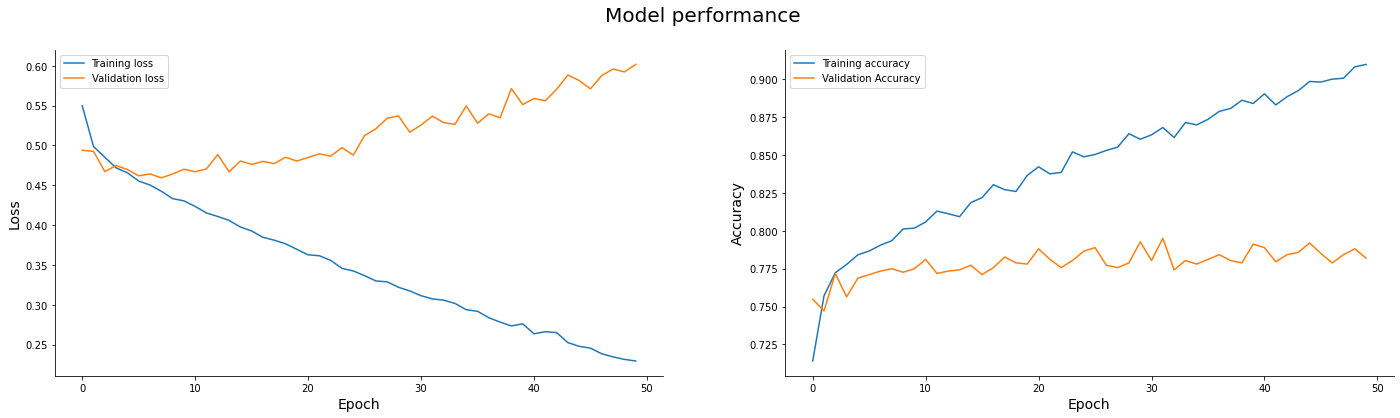

In [15]:
model = build_and_train(
    callbacks=[MyCallback()],
    num_epochs=50
)